<a href="https://colab.research.google.com/github/RoshanChongder/IMAGE-PROCESSING-AND-FACIAL-EMOTION-DETECTION/blob/master/Capture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dependencies .


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2 , PIL , io , html , time , os 
import numpy as np 
from keras.preprocessing import image
from keras.models import model_from_json 

In [ ]:
#drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/
model = model_from_json( open('drive/MyDrive/EmotionDetection/Model_Training_Op/24_06/model/fer.json','r').read() )
# drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/
model.load_weights( 'drive/MyDrive/EmotionDetection/Model_Training_Op/24_06_1/model/fer.h5' )
print('The model is been loadded with weights')

The model is been loadded with weights


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img


def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png') # format bbox into png for return
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))  # format return string

  return bbox_bytes
  

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
#Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [9]:
# start streaming video from webcam
video_stream() 

# label for video
label_html = 'Capturing...'

#face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# initialze bounding box to empty
bbox = ''
count , plot = 0 , []  
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    
    # grayscale image for face detection
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    faces_detected = face_cascade.detectMultiScale(gray_img) 
    
    for (x,y,w,h) in faces_detected:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        cropped_gray=gray_img[y:y+w,x:x+h]  # cropping the image 
        cropped_gray=cv2.resize(cropped_gray,(48,48))
        pixels = image.img_to_array(cropped_gray)
        pixels = np.expand_dims(pixels, axis = 0)
        pixels /= 255

        predictions = model.predict(pixels) 
        #print( predictions )
        #find max indexed array
        max_index = np.argmax(predictions[0]) 
        plot.append(max_index)
        
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(bbox_array, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes



<IPython.core.display.Javascript object>

In [20]:
print(set(plot))
d = {}
for i in plot:
  if i in d :
    d[i]+=1
  else :
    d[i] = 1
print(d)
tags , count = ['angry', 'happy', 'sad', 'surprise', 'neutral'] , [] 
for i in sorted(d.keys()) :
  count.append(d[i])
print(tags,count)

{0, 3, 4, 5, 6}
{6: 39, 3: 21, 5: 20, 0: 42, 4: 3}
['angry', 'happy', 'sad', 'surprise', 'neutral'] [42, 21, 3, 20, 39]


['angry', 'happy', 'sad', 'surprise', 'neutral'] [42, 21, 3, 20, 39]


<BarContainer object of 5 artists>

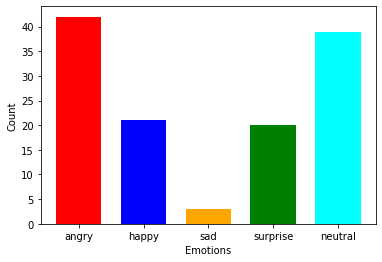

In [29]:
# plotting the bar graph 
import matplotlib.pyplot as plt
print(tags,count)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.bar(tags,count,color = ['red', 'blue', 'orange', 'green', 'cyan'] , width = [0.7]*5 )
